## Application of the small world example

Ok. Turns out this part did not have any actual technical details for modelling
the small world example data. I will hence try to reproduce the posterior
updating that they have in Figure 2.5.

* Step 1: I'll define the raw data and convert it into binary output.

* Step 2: Since the data is binary, and I am making the assumptions that (1) each toss of the globe is independent of th previous, (2) the probability of landing on water ("W") is the same at each toss, I will assume $y_i | p \sim Bernoulli(p)$,
and use a Beta prior as it is the prior. My working model is defined as follows
$$
y_i | p \sim Bernoulli(p)\\ p \sim Beta(\alpha, \beta)
$$
As such, the likelihood of the data $(y_1, \ldots, y_n) \mid p$ is
$$
p(y_1,\ldots, y_n \mid p) \propto p^{\sum_{i=1}^n y_i}(1-p)^{n - \sum_{i=1}^n}
$$
which is $binomial$. Why choose the $Beta$ as my prior? Purely due to the consequence that it is the 
conjugate prior of the binomial density. As for the hyperparameters 
($\alpha$, $\beta$) of the $Beta$ prior, my quick prior belief is that landing 
on water and land is of equal probability. That is, my prior belief is that 
$p=0.5$ (in reality I know that there is much more water than land but I want to
see the evolution of the posterior as I add data). Using the $Beta$ as my prior,
I will choose $\alpha = \beta = 2$ so that the mean satisfies 
$$
\mathbf{E}[p] = \frac{\alpha}{\alpha + \beta} = 0.5\,.
$$
Since the Beta distribution is the conjugate prior to the binomial, our posterior
updates will remain $Beta$ where the updated parameters are reflected as follows
$$
    p | y \sim Beta(\alpha + s, \beta + f)
$$
where $s$ is the number of successes, and $f$ is the number of failures.

* Step 3: Code this up manually as we have a closed form for the posterior. 
Save the density at each additional data point update to gather the evolution of 
the posterior.

* Step 4: Plot the evolution of the posteriors of $p$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, binom

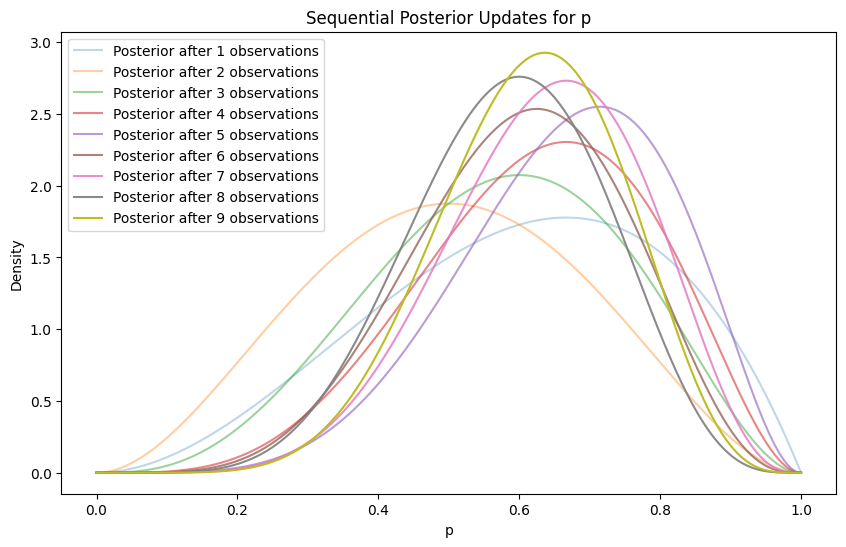

In [2]:
# The raw data
raw_df = ["W", "L", "W", "W", "W", "L", "W", "L", "W"]

# Change column of W's and L's to 1's and 0's for binary application
df = np.array([1 if d == "W" else 0 for d in raw_df])

## Define our model
# Initial params
alpha_param = 2
beta_param = 2
p_grid = np.linspace(0, 1, 500)
n = len(df)

plt.figure(figsize=(10,6))

# iterative update of posterior
for i, obs in enumerate(df, start=1):
    # Update posterior params
    alpha_param += obs
    beta_param += 1 - obs
    
    # Compute updated posterior
    p_posterior = beta.pdf(p_grid, alpha_param, beta_param)

    # Plot updates
    opacity = 0.2 + 0.8 * (i / n)
    plt.plot(
        p_grid,
        p_posterior,
        # color='tab:blue',
        alpha=opacity,
        label=f"Posterior after {i} observations"
    )

plt.xlabel('p')
plt.ylabel('Density')
plt.title('Sequential Posterior Updates for p')
plt.legend()
plt.show()

Just out of curiosity, I also want to compare the above which uses the conjugacy
between the likelihood and prior to conclude a $Beta$ distribution and just use
the direct proportion $Likelihood \times Prior$. Since I am adding one datum at
a time, the likelihood function I am now dealing with is a $Bernoulli$. I will
still utilize $Beta(2,2)$ as the initial prior.

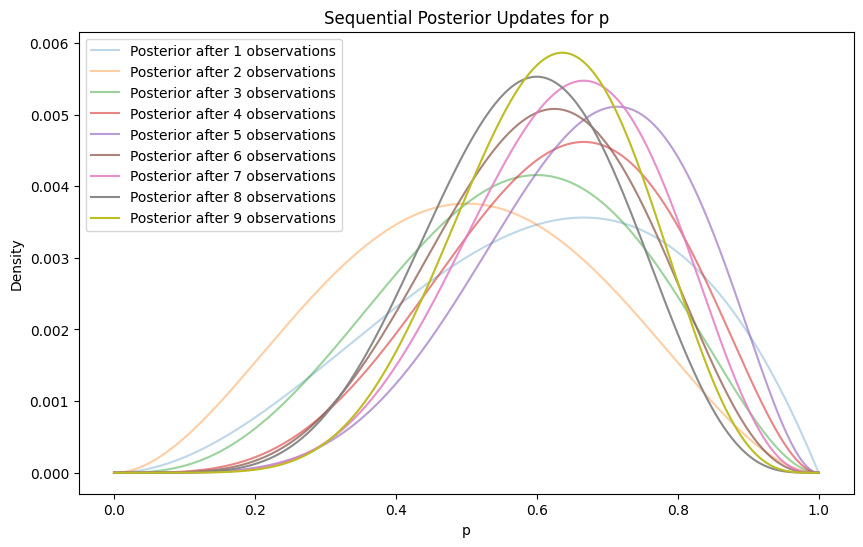

In [17]:
## Define our model
# Initial params
p_grid = np.linspace(0, 1, 500)
n = len(df)

plt.figure(figsize=(10,6))

# Iterative update of posterior
# Initial posterior
prior_init = beta.pdf(p_grid, 2, 2)
p_posterior = prior_init.copy()
# Updating posterior
for i, obs in enumerate(df, start=1):
    # Updates
    is_success = obs
    likelihood = binom.pmf(k = is_success, n = 1, p = p_grid)
    # Compute posterior
    p_posterior = likelihood * p_posterior
    # Standardize
    p_posterior = p_posterior / np.sum(p_posterior)

    # Plot updates
    opacity = 0.2 + 0.8 * (i / n)
    plt.plot(
        p_grid,
        p_posterior,
        # color='tab:blue',
        alpha=opacity,
        label=f"Posterior after {i} observations"
    )

plt.xlabel('p')
plt.ylabel('Density')
plt.title('Sequential Posterior Updates for p')
plt.legend()
plt.show()


Nice! We get the same result as using conjugacy!

## Quadratic Approximation Code for Globe Example

The book states two steps are required to perform Quadratic Approximation for
computing the posterior.

(1) Find the posterior mode (accomplished using optimization algorithm),

(2) Utilize numerical techniques to approximate the curvature near the mode.

The posterior mode is the the MAP estimator. Since our globe example was designed
so that we are working with conjugate priors, our MAP estimator has a closed form
solution. The MAP estimator for a binomial given beta prior is defined as follows. 
Given:
$$
    (y_1, \ldots, y_n) \mid p \sim Binom(n, p)\\
    p \sim Beta(\alpha, \beta)
$$
we have that
$$
    \pi(p \mid \mathbf{y}) \sim Beta(\alpha + s, \beta + f)
$$
with posterior mode
$$
    p_{MAP} = \frac{\alpha + s - 1}{\alpha + s + \beta + f - 2}
$$
where $s$ is the number of successes and $f$ is the number of failures. In our case
$\alpha = \beta = 2$, $s = 6$ and $f = 3$ 

(NOTE: this equation is just the mode of a 
Beta distribution with parameters $(\alpha + s)$ and $(\beta + f)$.)

In [31]:
a,b = 2,2
s = np.sum(df)
f = len(df) - s
p_posterior = beta.pdf(p_grid, a+s, b+f)

# Getting the posterior mode
p_MAP = (a + s - 1) / (a + s + b + f - 2)
print(f"The posterior mode is approx. {p_MAP:.3f}")

The posterior mode is approx. 0.636


Now that we have the posterior mode, we find a quadratic (Laplace) approximation
of the curvature around said point. Let 
$$
    \ell(p) = \log \pi(p \mid \mathbf{y})
$$
be the log posterior (I'm using $\pi$ to indicate the posterior here as we are
already using $p$ for the parameter). The Laplace approximation around $p_{MAP}$
is found by taking a second-order Taylor's expansion of $\ell$ about $p_{MAP}$ then
exponentiating to get a quadratic form for $\pi$:
$$
    \ell(p) \approx \ell(p_{MAP}) - \frac{1}{2} (- \ell''(p_{MAP}))\,(p - p_{MAP})^2\\
    \implies \pi(p \mid \mathbf{y}) = \pi(p_{MAP} \mid \mathbf{y}) \cdot
    \exp\left\{ - \frac{1}{2} [-\ell''(p_{MAP})]\, (p - p_{MAP})^2 \right\}\\
    \implies \pi(p \mid \mathbf{y}) \propto \mathcal{N}\left(p_{MAP},\; [-\ell''(p_{MAP})]^{-1}\right)\,.
$$
So we can approximate our posterior distribution as a Normal with mean $p_{MAP}$ 
and variance $\left[\ell''(p_{MAP})\right]^{-1}$. In our case, I hand computed
$$
    \ell''(p) = \frac{(1-\alpha - s)}{p^2} + \frac{(1 - \beta - f)}{(1-p)^2}.
$$

The inverse of this is our variance. Simplifying and inverting we get
$$
    \text{Var}(p) \approx \left[\frac{-(1-\alpha - s)(1-p_{MAP})^2 - (1-\beta - f)p_{MAP}^2}{p_{MAP}^2(1-p_{MAP})^2}\right]^{-1}
$$


Let us now compute all of this in code.

In [32]:
from scipy.stats import norm

In [89]:
def compute_approx_var(p, a, b, s, f):
    return (p**2 * (1-p)**2) / (-1.0 * ( 1 - a - s ) * ( 1 - p )**2 - ( 1 - b - f ) * p**2)


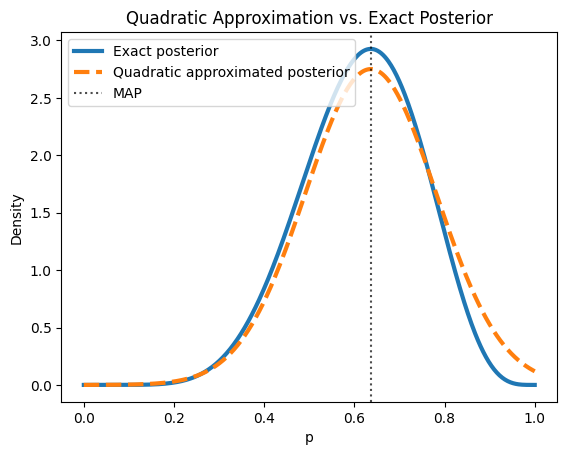

In [94]:
# Params for normal
approx_mean = p_MAP
approx_var = compute_approx_var(p_MAP, a, b, s, f)
approx_std = np.sqrt(approx_var)

# Posterior approximation
p_post_approx = norm.pdf(p_grid, loc=approx_mean, scale=np.sqrt(approx_var))

# Plot
plt.plot(
    p_grid,
    p_posterior,
    linewidth=3,
    label="Exact posterior"
)

plt.plot(
    p_grid,
    p_post_approx,
    linestyle="--",
    linewidth=3,
    label="Quadratic approximated posterior"
)

plt.axvline(
    p_MAP,
    color="black",
    linestyle=":",
    alpha=0.7,
    label="MAP"
)

plt.xlabel("p")
plt.ylabel("Density")
plt.title("Quadratic Approximation vs. Exact Posterior")
plt.legend()
plt.show()

Now let us perform the same thing using Pyro library to do the heavy machinery
for us! (Of course using Pyro for a problem that has closed-form solutions is
overkill but it allows me to practice Pyro syntax)

In [54]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive 
from pyro.infer.autoguide import AutoDelta
import pyro.optim as optim

pyro.set_rng_seed(42)

In [68]:
# Data (needs to be torch tensor)
data = ['W', 'L', 'W', 'W', 'W', 'L', 'W', 'L', 'W']
y = torch.tensor([1.0 if d == 'W' else 0.0 for d in data])

# Model in Pyro
a, b = 2.0, 2.0
def model(data):
    # Prior
    p = pyro.sample("p", dist.Beta(a, b))

    # Likelihood for each Bernoulli obs
    with pyro.plate("data", len(y)):
        pyro.sample("obs", dist.Bernoulli(p), obs=y)

In [69]:
# Getting the MAP estimate
guide = AutoDelta(model)
optimizer = optim.Adam({"lr": 0.05})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Run optimization
num_steps = 2000
for step in range(num_steps):
    loss = svi.step(df)

# Get MAP estimate
p_MAP_pyro = guide()["p"].item()
print("MAP estimate:", p_MAP_pyro)

MAP estimate: 0.6363636255264282


Amazing! This matches the analytic work I performed above! Let us continue to
compute the second-derivative of the log posterior at the MAP estimate.

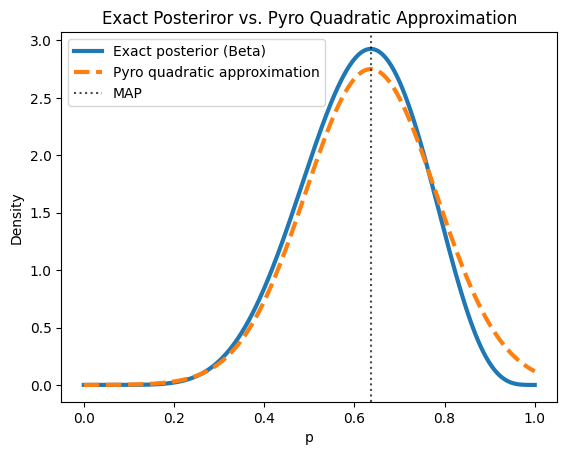

In [ ]:
# Pyro works with torch tensors
p_hat = torch.tensor(p_MAP_pyro, requires_grad=True)

# Compute log posterior 
log_prior = dist.Beta(a, b).log_prob(p_hat)
log_likelihood = dist.Bernoulli(p_hat).log_prob(y).sum()
log_posterior = log_prior + log_likelihood

# First derivative of log posterior
grad = torch.autograd.grad(log_posterior, p_hat, create_graph=True)[0]

# Second derivative of log posterior
grad2 = torch.autograd.grad(grad, p_hat)[0]

# Compute variance
pyro_mean = p_MAP_pyro
pyro_var = -1.0 / grad2.item()
pyro_std = pyro_var**0.5

# Plot the posteriors
pyro_post = norm.pdf(p_grid, loc=pyro_mean, scale=pyro_std)
plt.plot(
    p_grid,
    p_posterior,
    label="Exact posterior (Beta)",
    linewidth=3
)

plt.plot(
    p_grid,
    pyro_post,
    linestyle="--",
    linewidth=3,
    label="Pyro quadratic approximation"
)

plt.axvline(
    p_MAP_pyro,
    color="black",
    linestyle=":",
    alpha=0.7,
    label="MAP"
)

plt.xlabel("p")
plt.ylabel("Density")
plt.title("Exact Posteriror vs. Pyro Quadratic Approximation")
plt.legend()
plt.show()

This also aligns with the plots we got above! COOL!